# CUNY DATA622 Final Project
## Natural Language Processing - DAIGTv2 Dataset
## Predicting Topics of Text Blurbs
### Daniel Craig
### 12/17/2023


This dataset was originally meant for the Detect AI Competition on Kaggle as a baseline dataset to be used with a "Human" or "AI - Generated" label for supervised learning. Handily, it also contained topics for each text blurb. I decided to re-purpose the dataset to practice applying several models using the "Bag of Words" approach in Natural Language Processing. 

The [dataset](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset/)

The [competition](https://www.kaggle.com/competitions/llm-detect-ai-generated-text)




### Train, Test, Split

This first section splits the data into training and test and grab the prompt names. These prompt names are what we will be predicting which category a given text blurb is a part of.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Dataset Source: https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset/
data = pd.read_csv("data/train_v2_drcat_02.csv")

X = data['text']
y = data['prompt_name']

target_names = y.unique() #grab the categories

Note that we are using the TF-IDF Vectorizer and removing stop words at the same time. The TF-IDF Vectorizer creates a feature for each word by calculating two things.

1. Term Frequency - $$\frac{\text{number of times a word appears in a document}}{\text{total number of terms in document}}$$
    - this represents a term's importance to a particular document
2. Inverse Document Frequency - $$log(\frac{\text{total number of documents}}{\text{number of documents containg the word}})$$
    - this represents a term's importance across all documents
    - the IDF will weaken words that appear in many documents and strengthen words that appear in only a few documents

Using this method, we can vectorize our words into numeric values that can be computed and interpreted by the models we will choose later. The "documents" in the context of this problem, would be the prompt categories or "prompt_name".

In [2]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 42)

# Vectorizing the words using TF-IDF
# Remove the stop words
vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
)

Vec_X_train = vectorizer.fit_transform(X_train)
Vec_X_test = vectorizer.transform(X_test)



From here, it'd be nice to get an idea of the most common words and how much they comprise each prompt category, to compare with the resulting powerful words to ensure the TF-IDF Vectorizer is appropriate. To visualize this, a quick plot of the most common words across all prompt names will be collected.

In [120]:
feature_names = vectorizer.get_feature_names_out() # grab the features
arrays_of_words = vectorizer.inverse_transform(Vec_X_train) # grab the words without stop words


# Pass a dictionary of the column name I want + the list of non-stop word arrays
words_df = pd.DataFrame({'Words': arrays_of_words})

# Join the words DataFrame with y_train along the columns (axis=1)
nonstop_data = pd.concat([words_df, data['prompt_name']], axis=1)


In [130]:
# Explode each array into an individual row for word with its associated category
nonstop_exploded = nonstop_data.explode('Words')

# Count the occurrences of words for each 'prompt_name'
top_words = (
    nonstop_exploded.groupby('prompt_name')['Words'].value_counts().groupby(level=0, group_keys=False).nlargest(5)
)

top_words

prompt_name                    Words
"A Cowboy Who Rode the Waves"  make     667
                               help     613
                               just     613
                               think    573
                               way      557
                                       ... 
The Face on Mars               make     805
                               help     770
                               just     686
                               way      685
                               think    642
Name: Words, Length: 75, dtype: int64

Help, just, make, school, think, and way are the most common words across all the prompt categories.

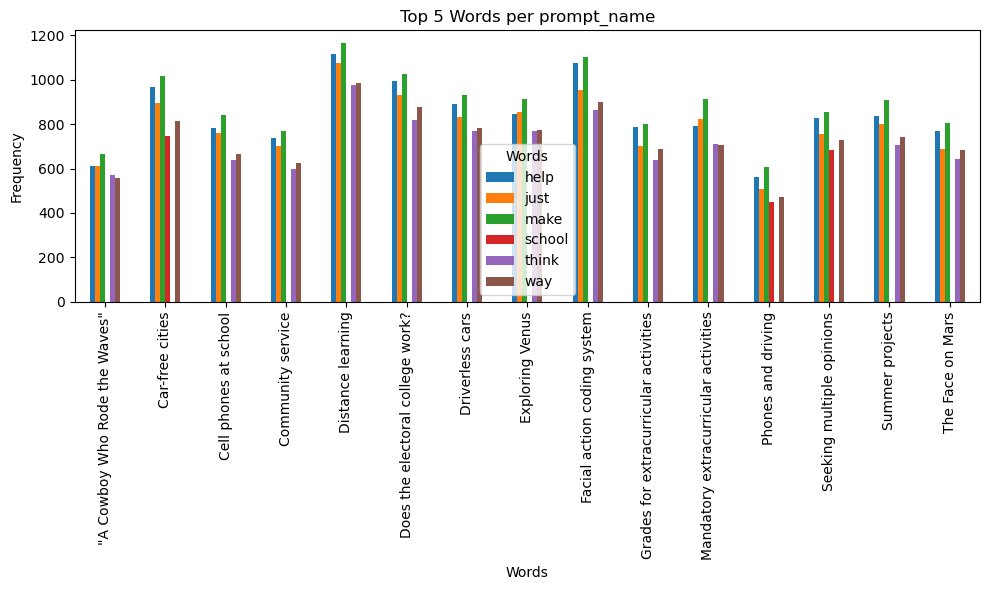

In [131]:
fig, ax = plt.subplots(figsize=(10, 6))

top_words.unstack().plot(kind='bar', ax=ax)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 6 Words per prompt_name')
plt.legend(title='Words')
plt.tight_layout()
plt.show()

In [105]:
from collections import Counter
import numpy as np

# Flatten the arrays
flattened_array = np.concatenate(arrays_of_words)

# Count words
word_counts = Counter(flattened_array)

# Get the 25 most common words and their frequencies
most_common_words = word_counts.most_common(10) 

# Display the most common words
print("Most common words:")
for word, frequency in most_common_words:
    print(f"{word}: {frequency}")

Most common words:
make: 13320
help: 12593
just: 11889
way: 11002
think: 10534
school: 9966
students: 9903
work: 9639
good: 9382
better: 9296


### Predicting Prompt Category

For this prediction, the "bag of words" approach will be used. It is quite simple, but is great for simple tasks. The concept behind the "bag of words" approach is to create a "bag of words" with their own relative value to each category, and use their frequency to determine what prompt category they are for.

Simplicty is the advantage, while lack of semantic meaning, context, and connotation is the disadvantage.

The words have already been valued with the use of the TFIDF Vectorizer. The next step is to establish the models for classification, and train them on the word values.

The first model will be the Ridge Classifier that uses Ridge regression.

##### Ridge Regression

Ridge regression is a variant of ordinary least squares (OLS) that aims to solve issues related to multi-collinearity and overfitting due to large coefficients. Ridge accomplishes this by introducing a regularization/punish term to the cost function of OLS.

$$\text{Cost}(w)= \frac{1}{2n} \sum_{n=1}^{n} (y_i - \hat{y_i})^2 + \sigma\sum_{n=1}^{n} w^2_i$$
​

The second term in the Cost equation above is the regularization term added to the OLS cost function to create Ridge Regression. This resulting cost value is then used to adjust and train the model.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Phones and driving'),
  Text(1, 0, 'Car-free cities'),
  Text(2, 0, 'Summer projects'),
  Text(3, 0, '"A Cowboy Who Rode the Waves"'),
  Text(4, 0, 'Mandatory extracurricular activities'),
  Text(5, 0, 'Exploring Venus'),
  Text(6, 0, 'Facial action coding system'),
  Text(7, 0, 'The Face on Mars'),
  Text(8, 0, 'Community service'),
  Text(9, 0, 'Grades for extracurricular activities'),
  Text(10, 0, 'Driverless cars'),
  Text(11, 0, 'Does the electoral college work?'),
  Text(12, 0, 'Cell phones at school'),
  Text(13, 0, 'Distance learning'),
  Text(14, 0, 'Seeking multiple opinions')])

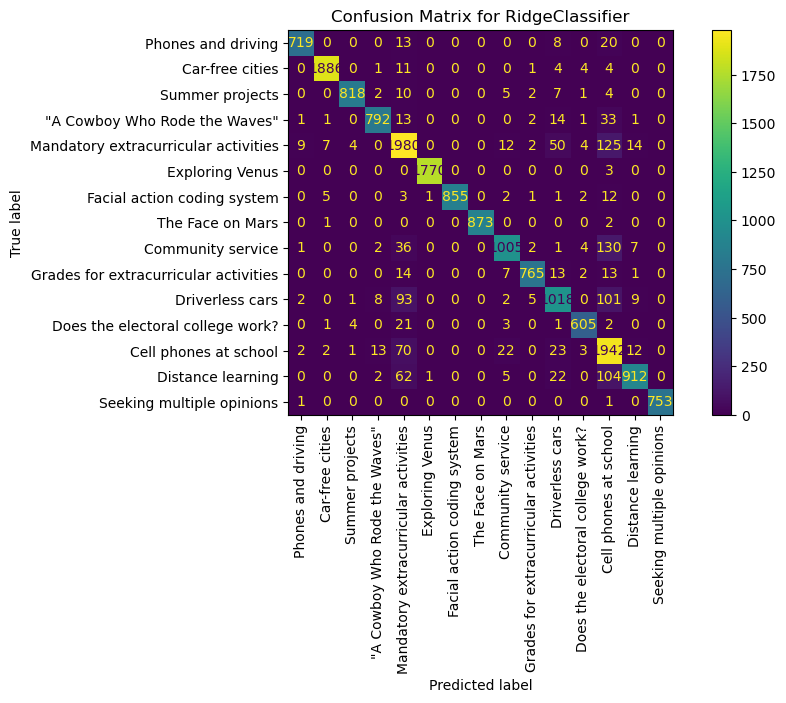

In [3]:

from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Establish our RidgeClassifier
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")

# Fit Ridge to data
clf.fit(Vec_X_train, y_train)

# Make predictions
pred = clf.predict(Vec_X_test)

# Start plot
fig, ax = plt.subplots(figsize=(10, 5))

# Confusion Matrix Disply has a method 'from_predictions' that allow you to reference predictions and actual values directly
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names) # Establishing tick labels from the groups
ax.yaxis.set_ticklabels(target_names) 
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}" # Referencing our classifier object's name directly
)
plt.xticks(rotation='vertical')



Overall, it looks like the toughest categories to predict were "Mandatory extracurricular activities" and "Cell phones at school". Otherwise it seems accurate overall.


### Which words were the most impactful for each document?


To do this, we can grab the coefficients applied to each word in the TF-IDF Feature Matrix. Knowing the structure of the dataset is important to do this. If the TF-IDF Feature Matrix is a row for each word, and its TF-IDF value, with columns of each prompt category, we can average the value of each word with respect to the prompt category and multiply it by the coefficients applied to that word for each prompt category to create a value for how much a word impacted a text blurb's likelihood of being classified to a category.

In [30]:
import numpy as np

average_feature_effects = clf.coef_ * np.asarray(Vec_X_train.mean(axis=0)).ravel()

for i, label in enumerate(target_names): #for each category in our target_names
    top5 = np.argsort(average_feature_effects[i])[-5:][::-1]  # Returns the indicies after it sorts a feature column of averages in ascending. take the last 5 (the largest), then reverse their order with [::-1] to make the top5 descending
    if i == 0: #on the first iteration
        top = pd.DataFrame(feature_names[top5], columns=[label]) #create a dataframe of the top features for the 0th column
        top_indices = top5 #set a new df equal to top5, so we can change top5 with each iteration
    else:
        top[label] = feature_names[top5] # Create the column of feature names by passing the indices from top5 to the feature_names df(which will grab the actual words)
        top_indices = np.concatenate((top_indices, top5), axis=None) #for iterations after the first, add the new indices for each feature column to top_indices
top_indices = np.unique(top_indices) # remove duplicates
predictive_words = feature_names[top_indices] # pull a df of the actual words using the indices


67

### Plotting Impact of each Word

Here we plot each word, and it's average impact per category. The words selected were the top 5 words in each category. With 15 categories, there should be 75 words, but was reduced down to 67 by only pulling unique words. This was done since the same words could have large impacts in multiple categories.

Words were plotted in groups of 4 to keep the plots readable. It's recommended to have a specific category or word in mind after scrolling through. It is difficult to discern meaning when viewing altogether.


Top 5 keywords per class (Range: 0-3):
  Phones and driving Car-free cities Summer projects  \
0           seagoing             car          phones   
1               luke            cars           phone   
2            cowboys           usage            cell   
3            animals        limiting          policy   

  "A Cowboy Who Rode the Waves" Mandatory extracurricular activities  \
0                     community                             students   
1                       service                               online   
2                          dear                               school   
3                          help                              classes   

  Exploring Venus Facial action coding system The Face on Mars  \
0       electoral                        cars            venus   
1            vote                  driverless           planet   
2         college                         car           author   
3       president                       drive          

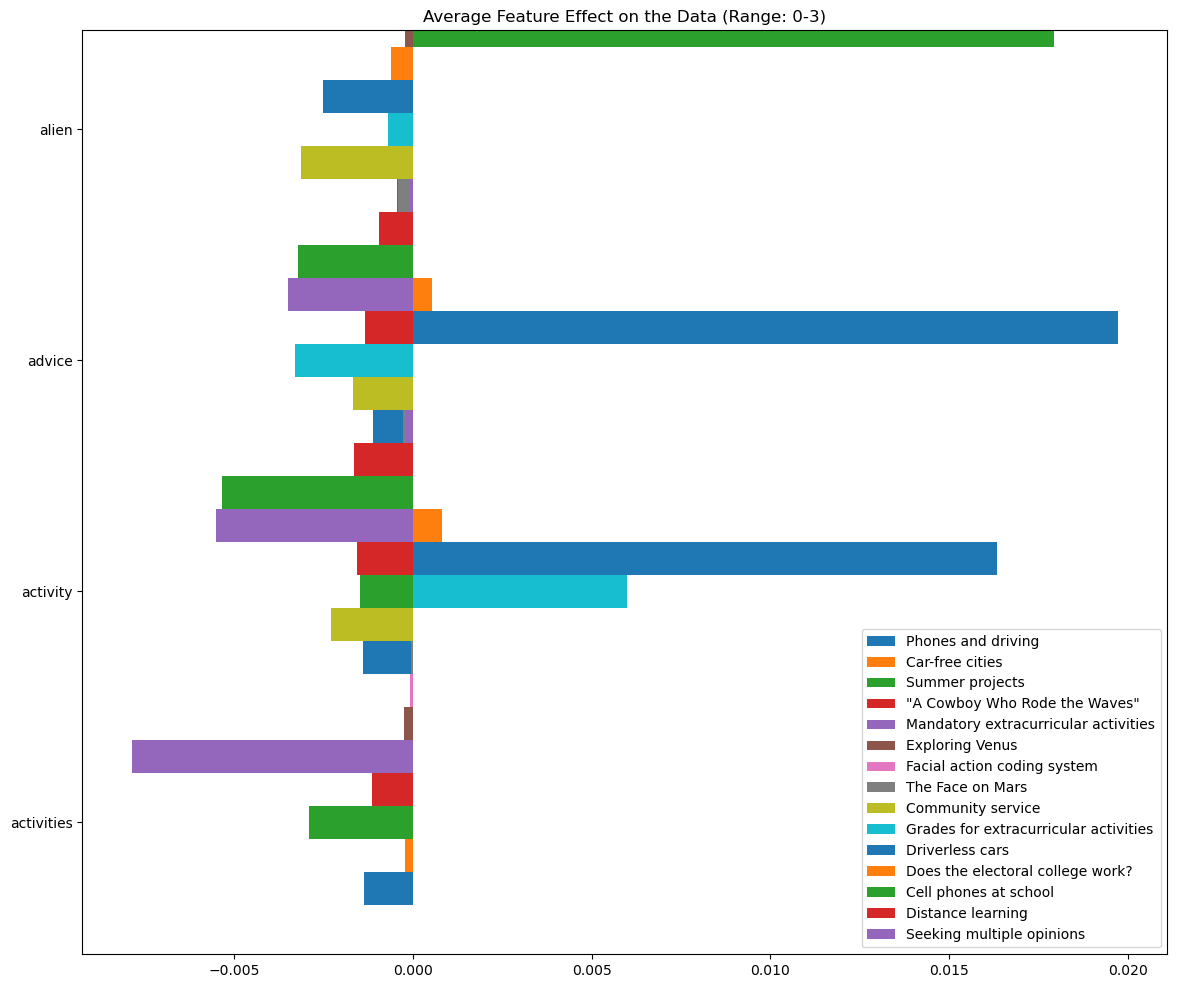

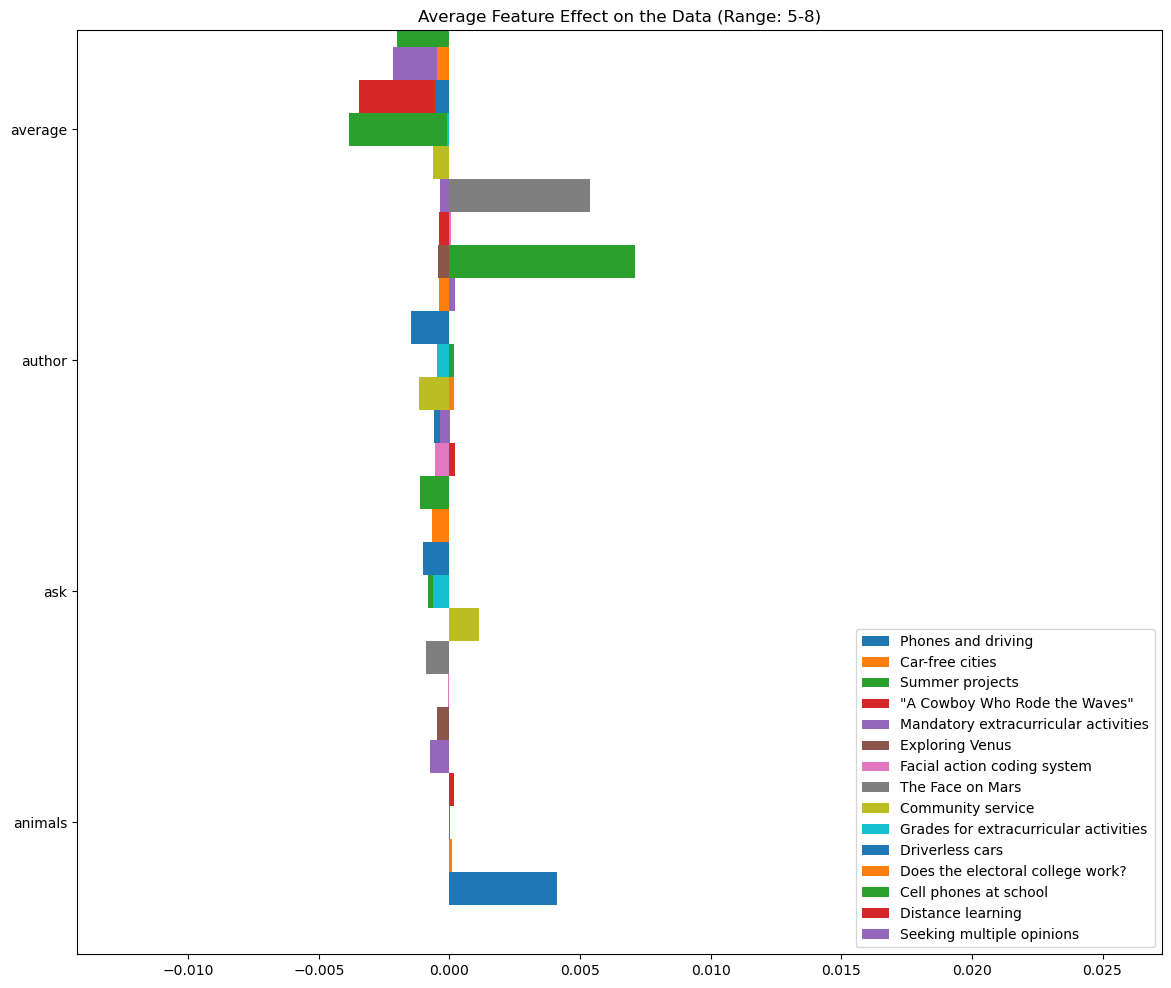

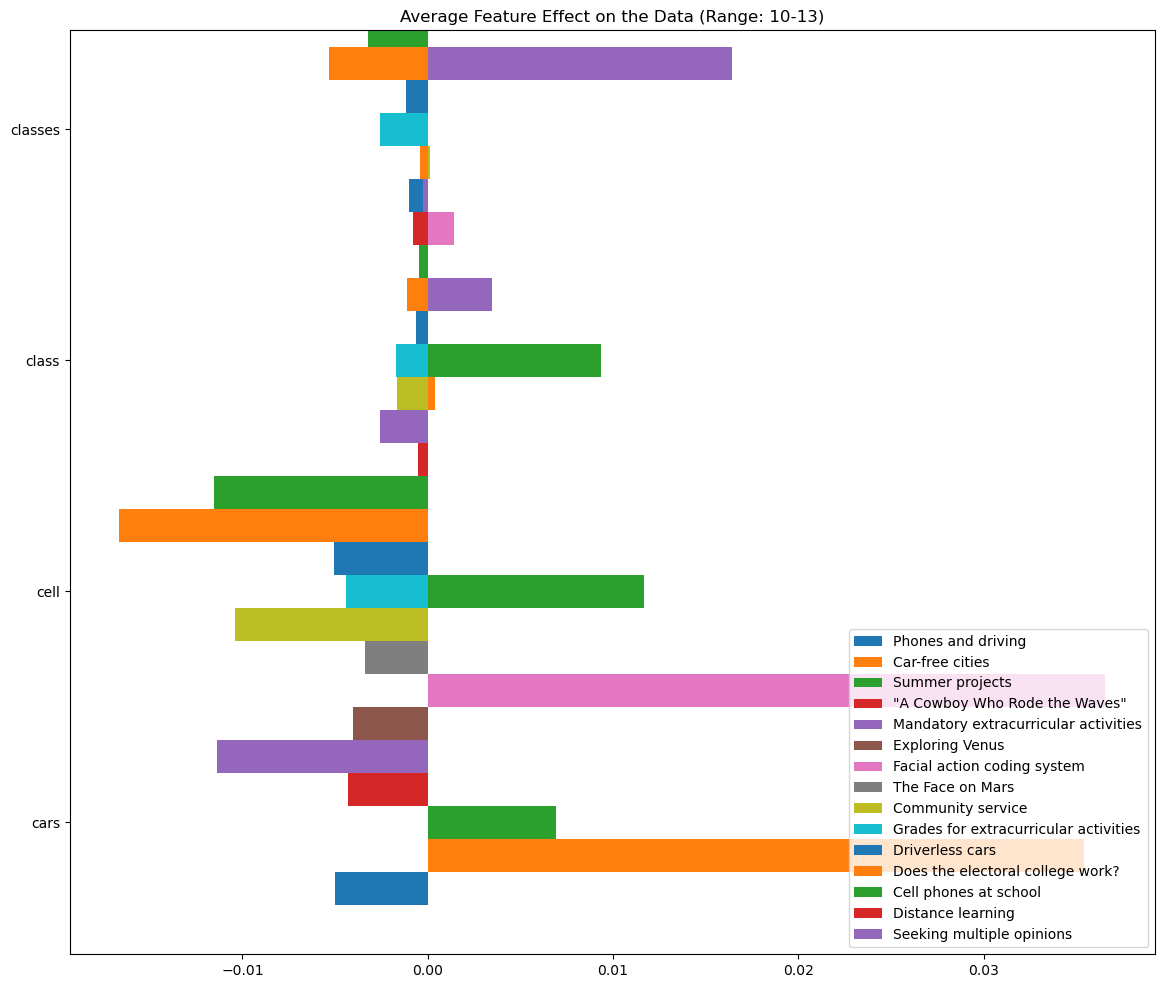

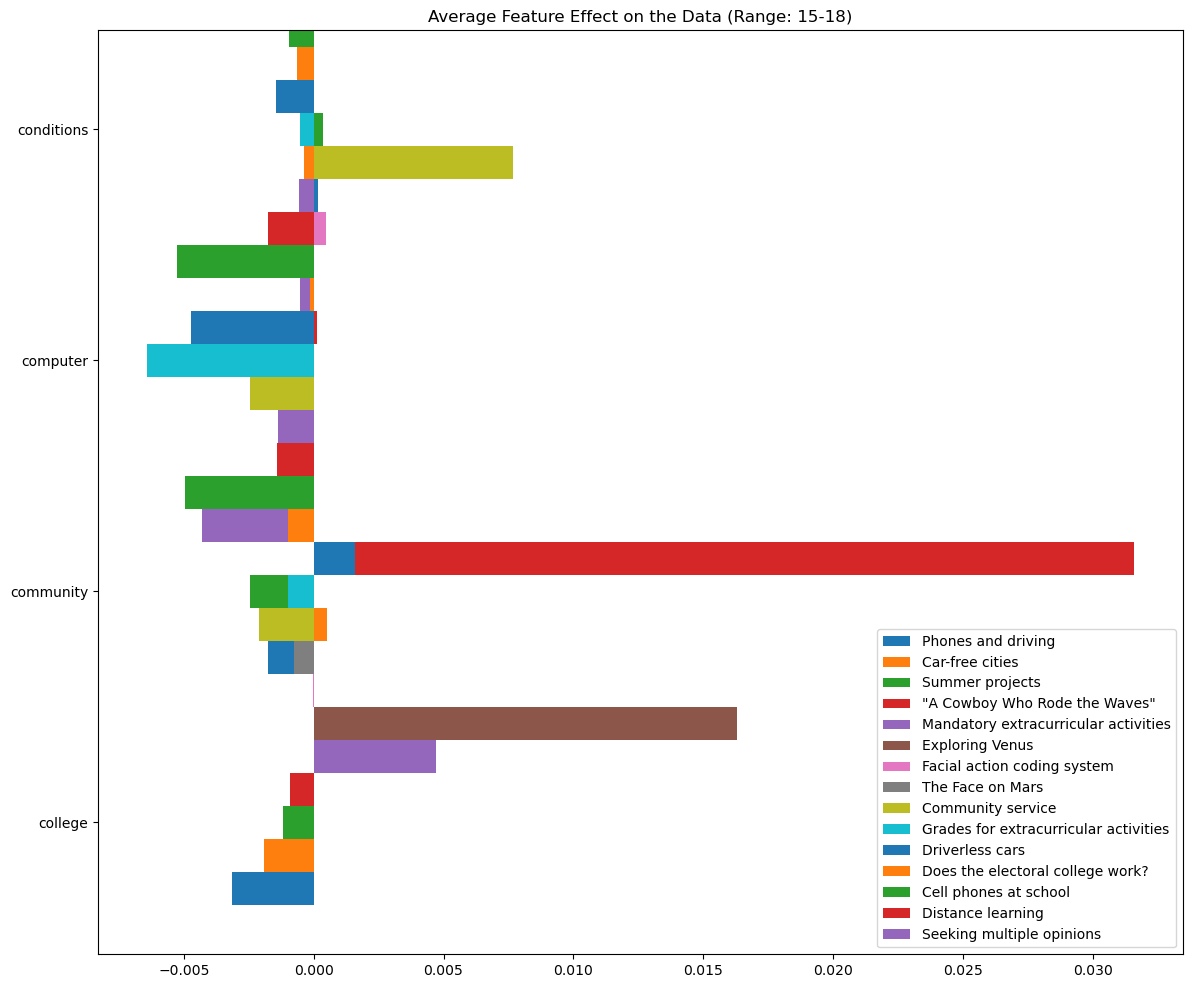

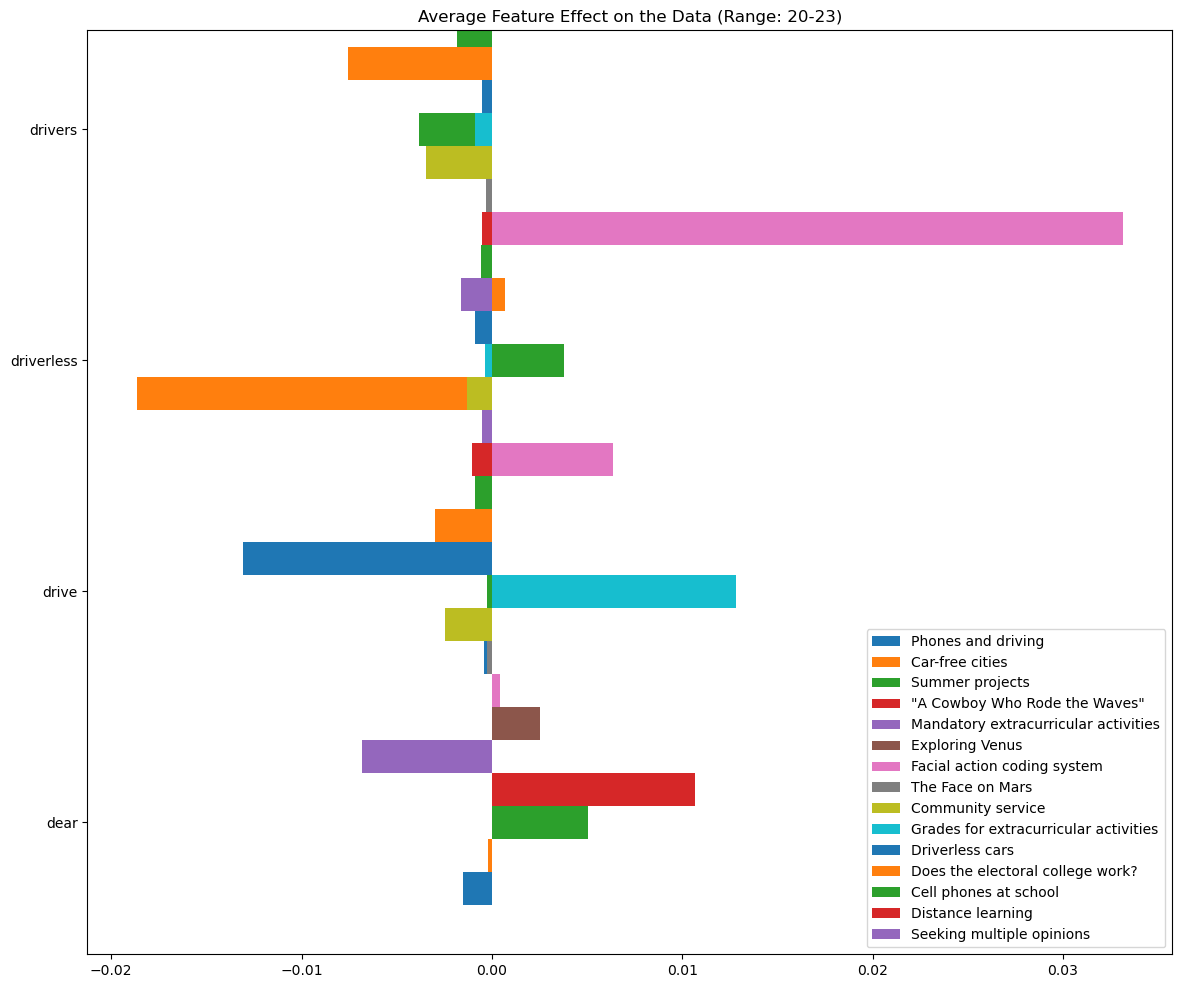

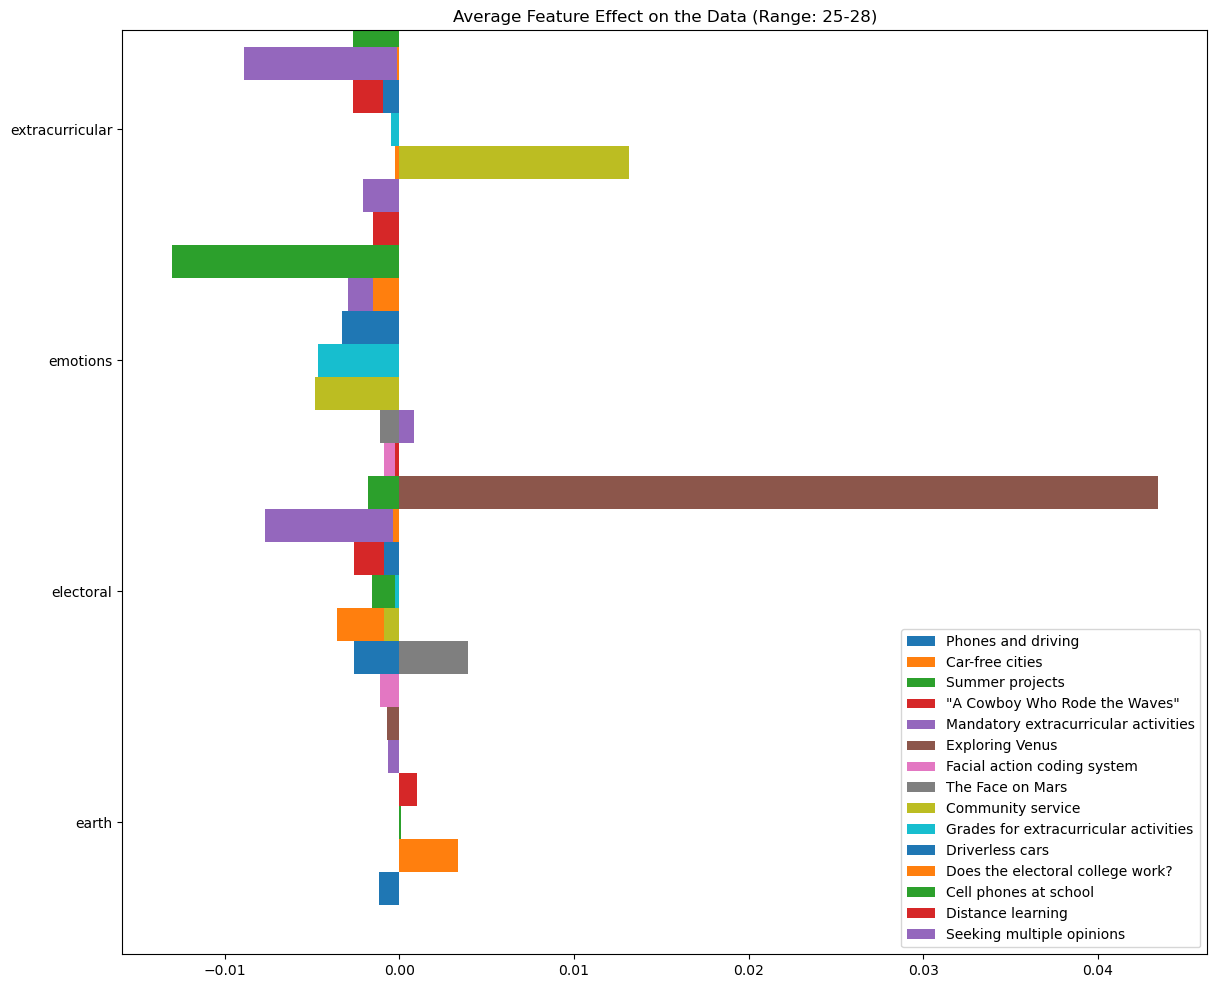

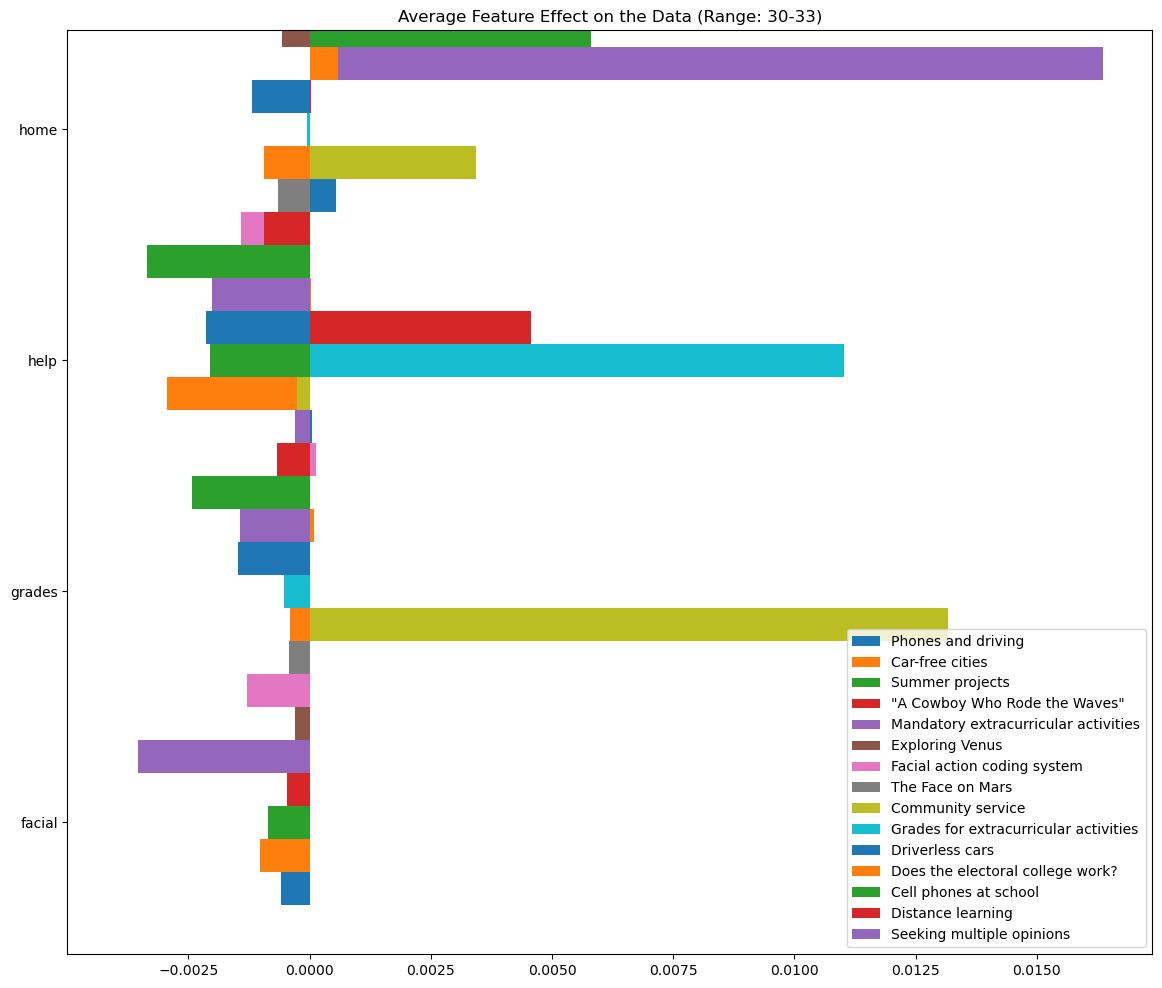

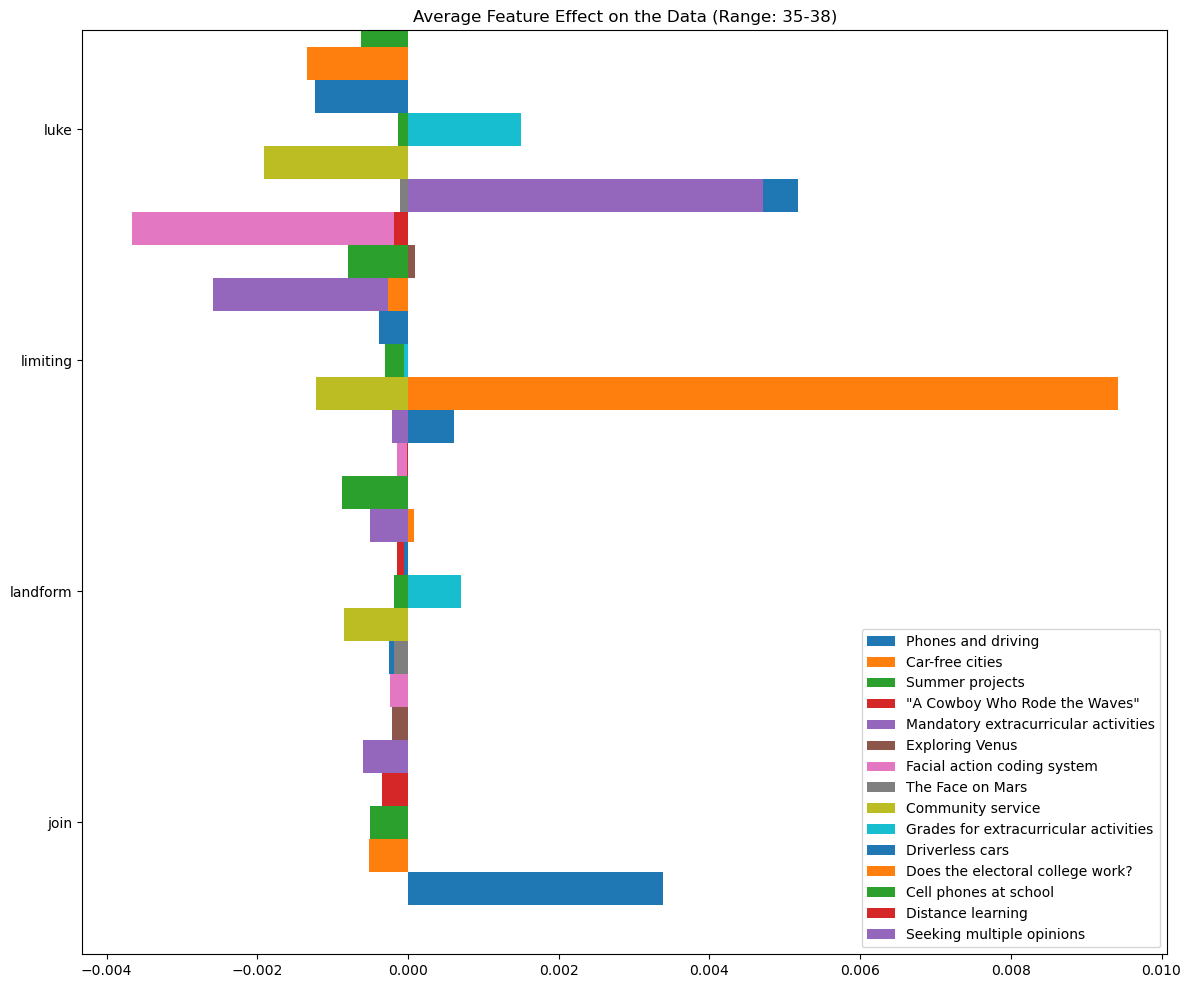

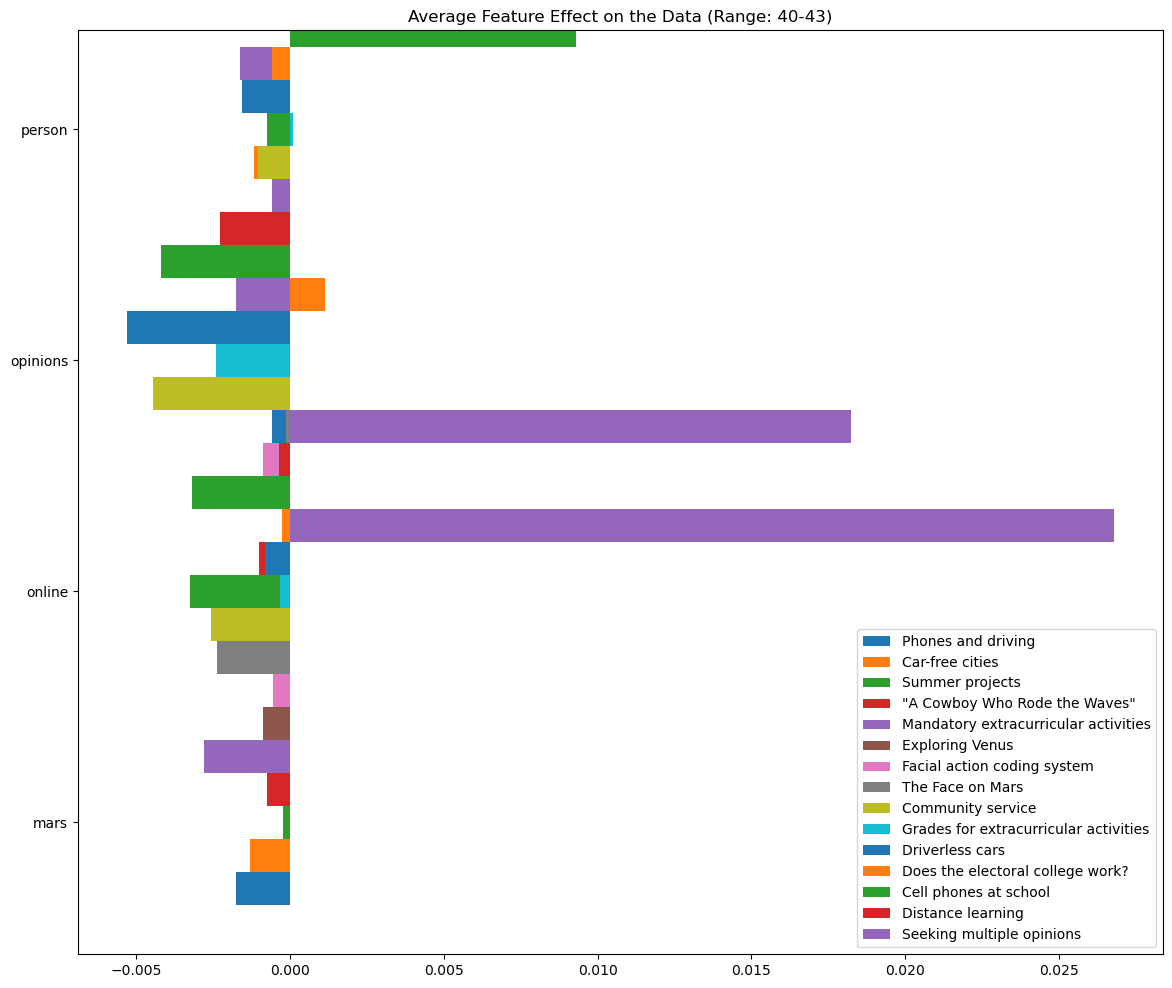

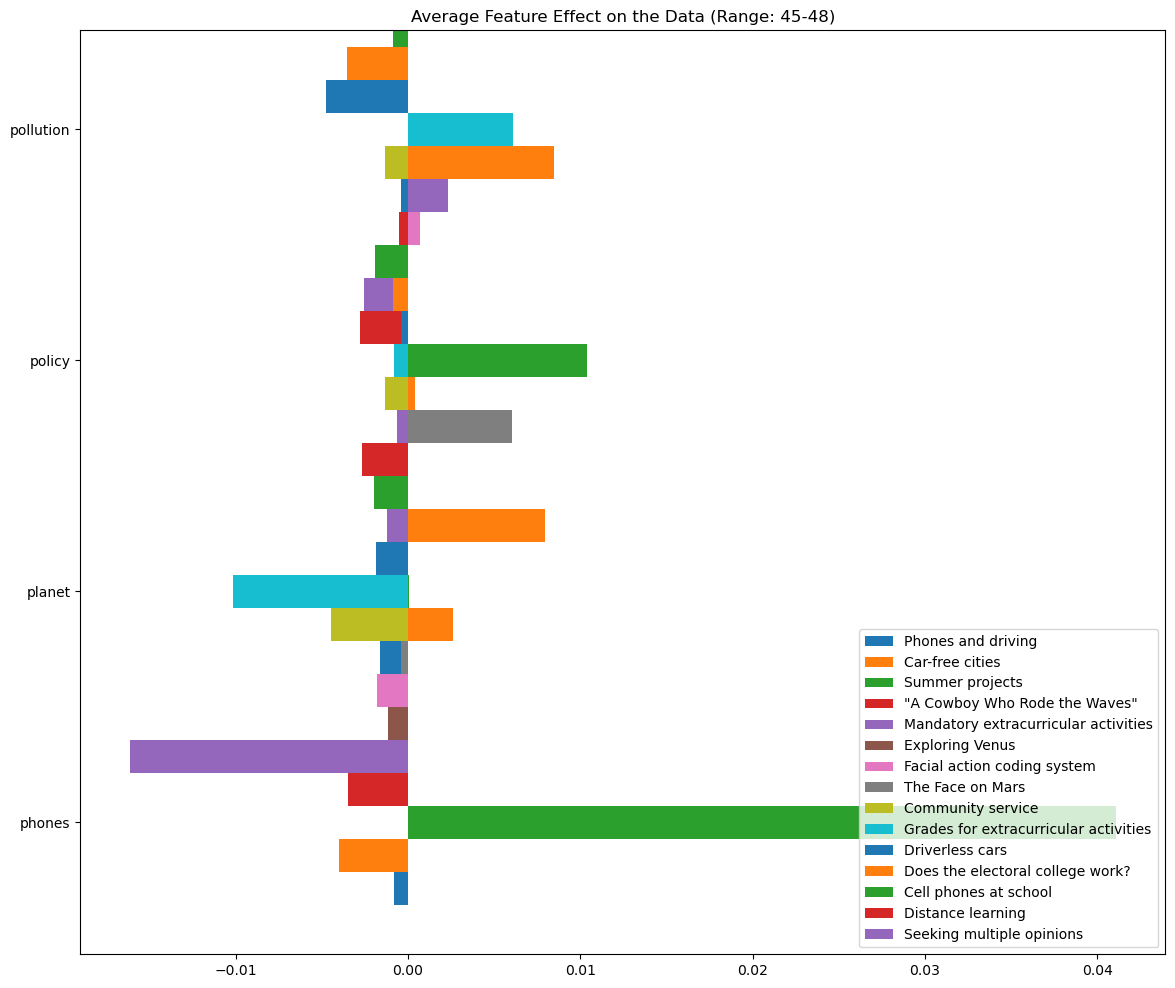

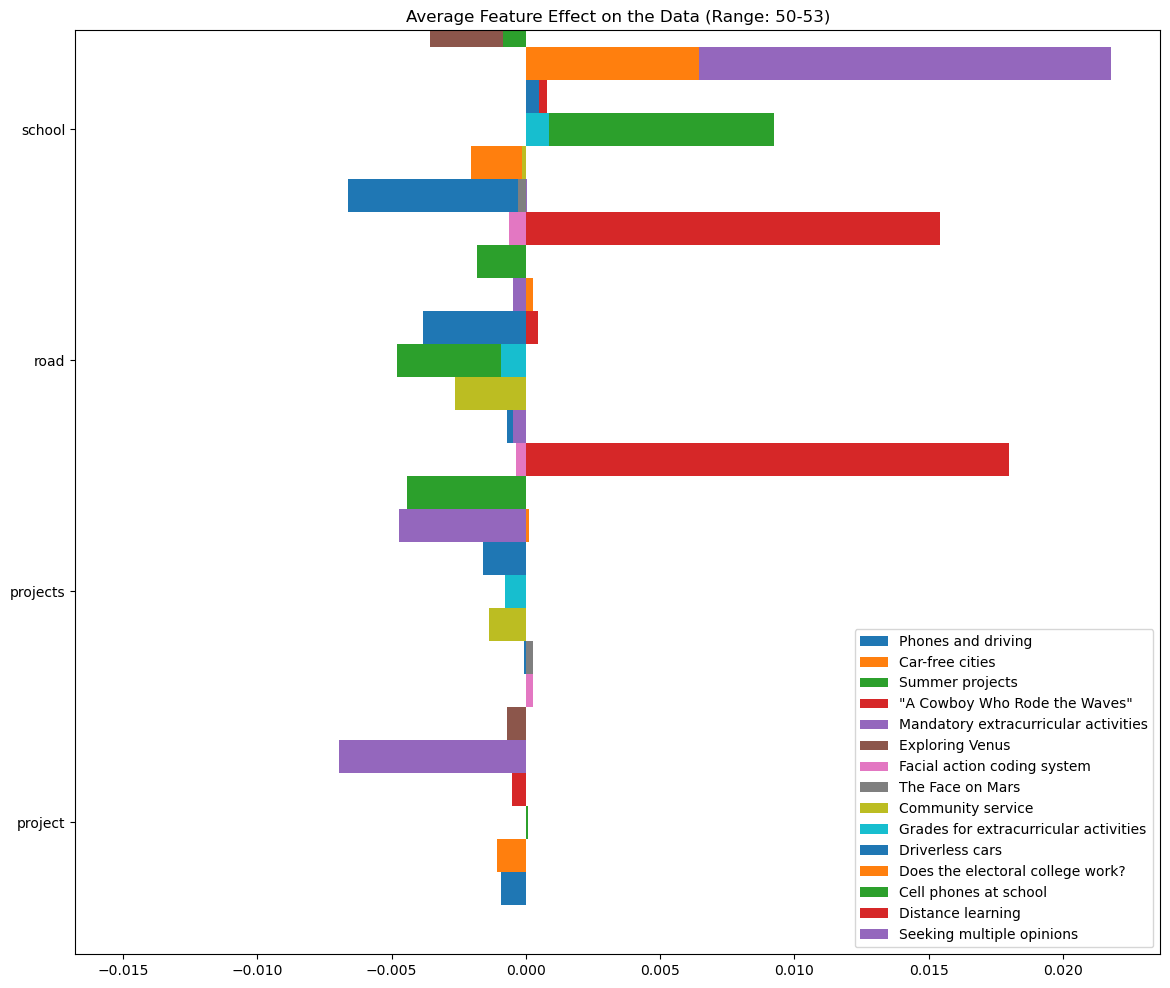

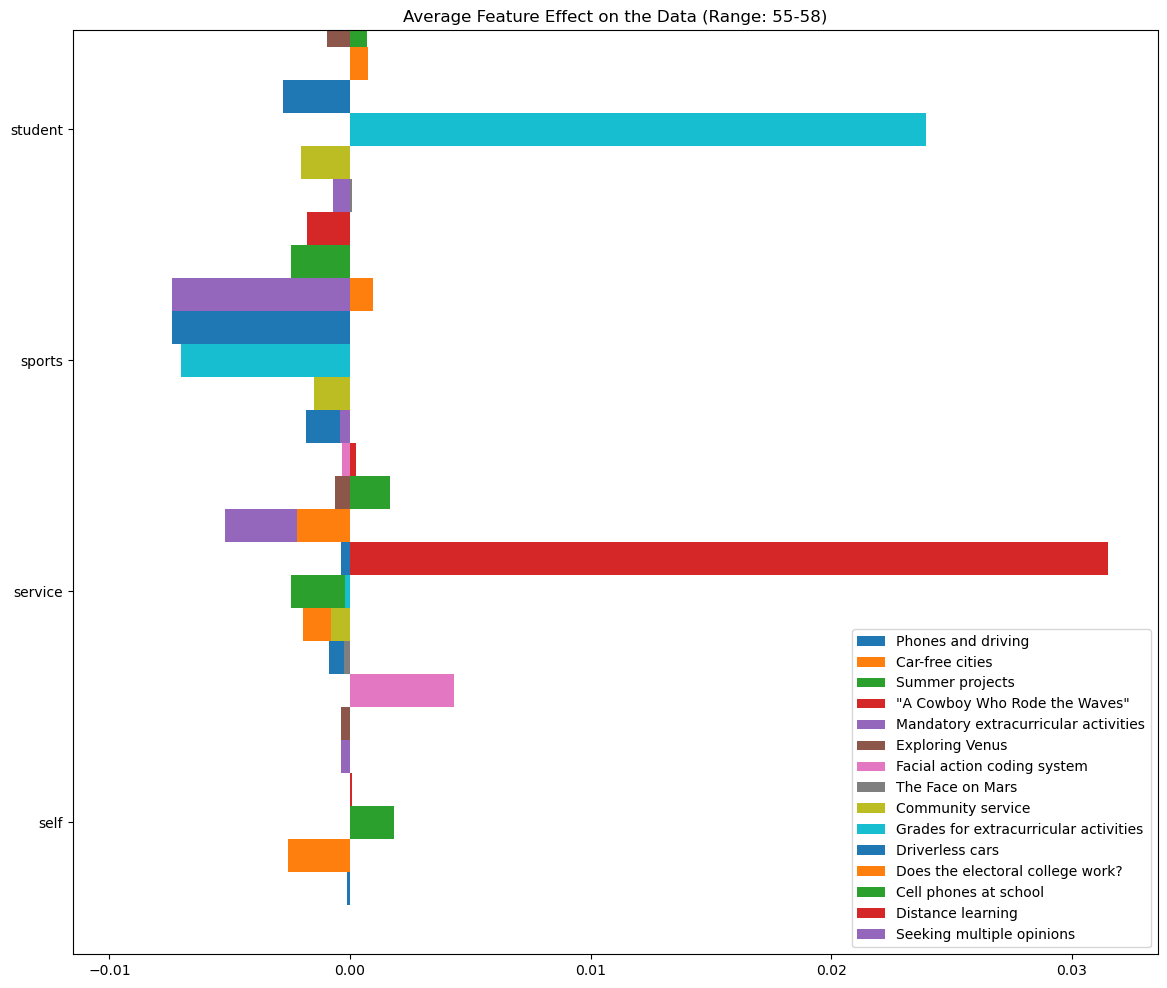

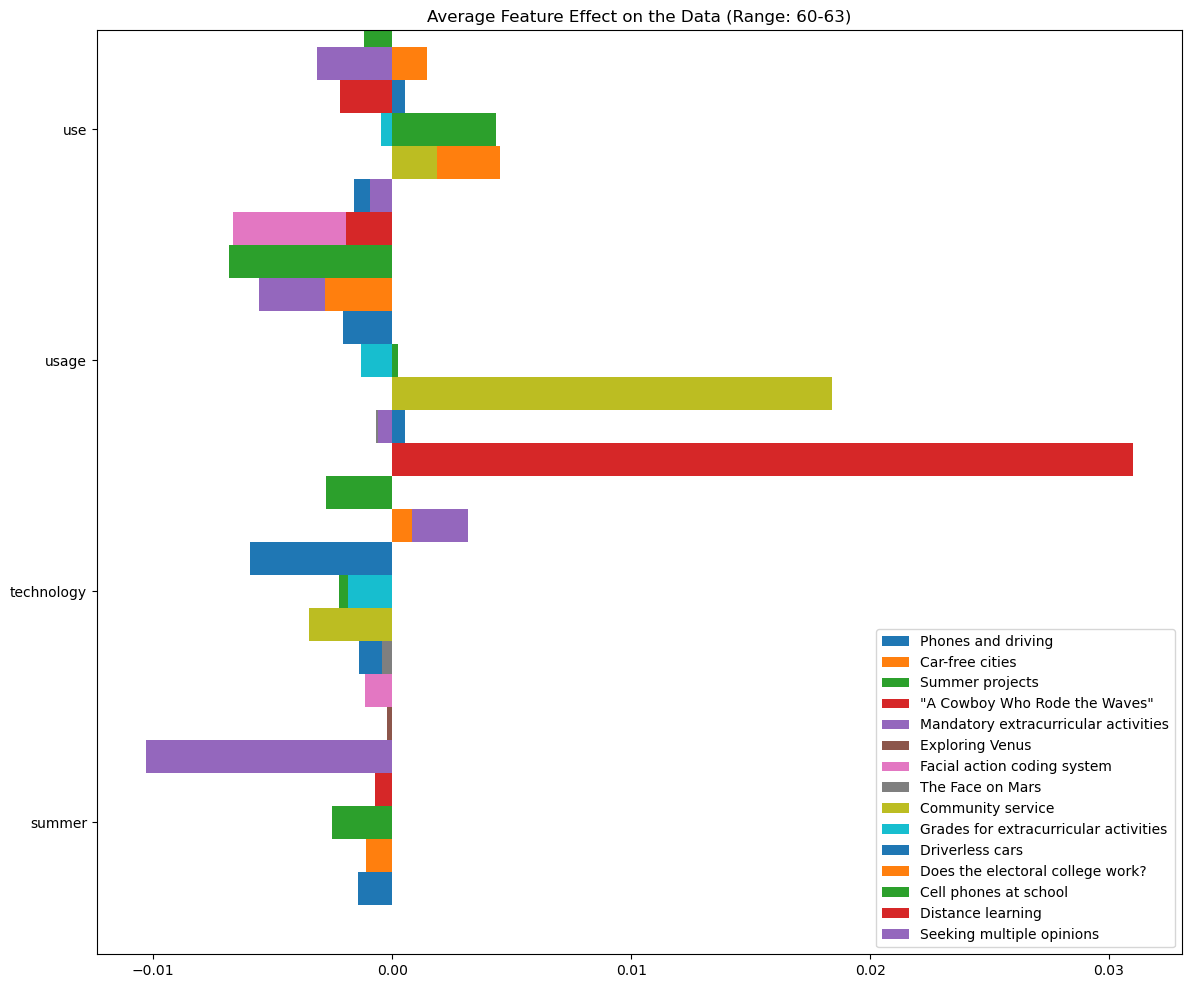

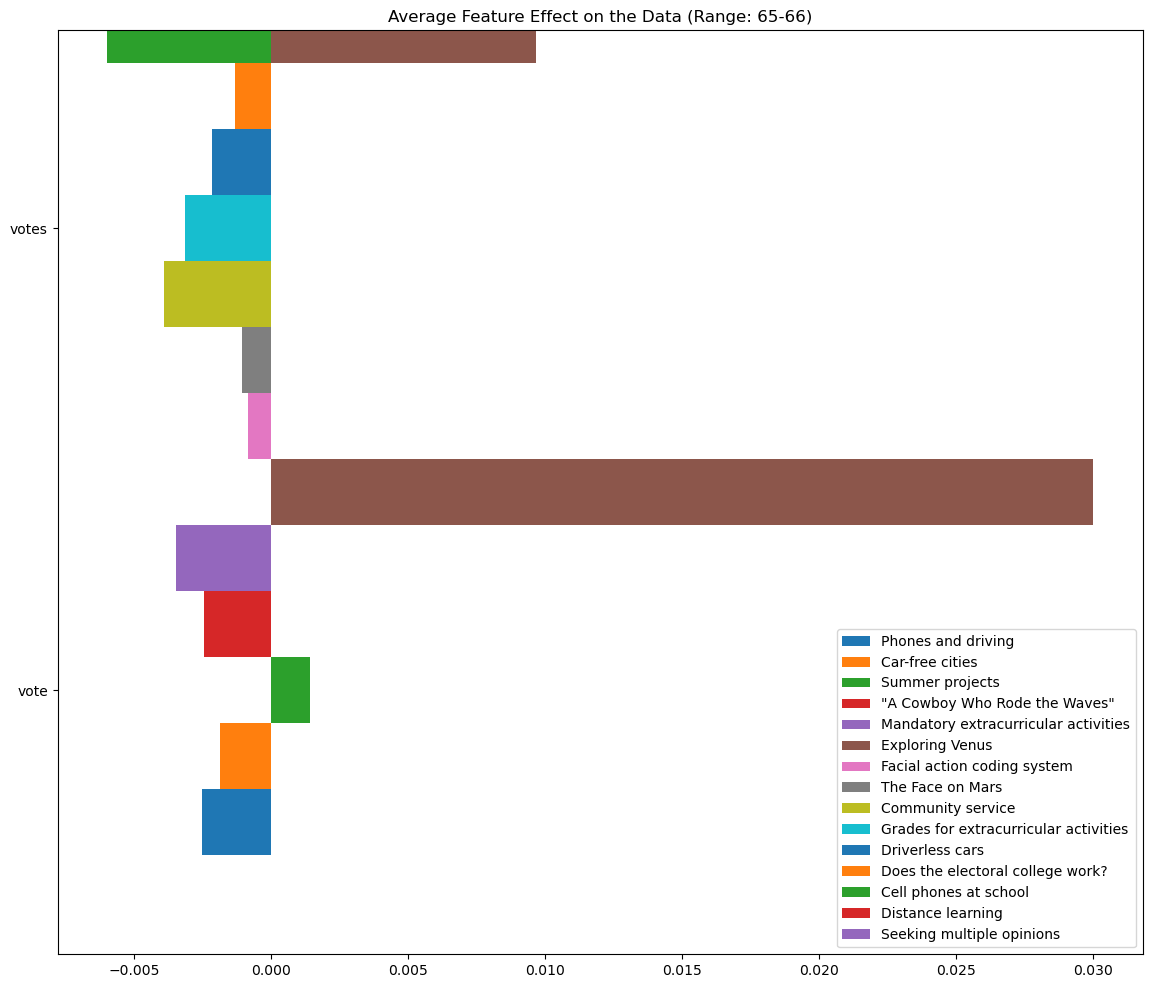

In [48]:
import numpy as np

bar_size = 0.25
padding = 0.75

ranges = [(0, 4), (5, 9), (10, 14),(15,19),(20,24),(25,29),(30,34),(35,39),(40,44),(45,49),(50,54),(55,59),(60,64),(65,67)]  # Define the ranges

for index, (start, end) in enumerate(ranges):
    y_locs = np.arange(len(top_indices[start:end])) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(14, 12))
    for i, label in enumerate(target_names): #for each category in our target_names
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices[start:end]],
            height=bar_size,
            label=label,
        )
    ax.set(
        title=f"Average Feature Effect on the Data (Range: {start}-{end-1})",
        yticks=y_locs,
        yticklabels=predictive_words[start:end],
        ylim=[
            0 - 4 * bar_size,
            len(top_indices[start:end]) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print(f"Top 5 keywords per class (Range: {start}-{end-1}):")
    print(top[start:end])

plt.show()


## Comparing to Other Methods

We will see the score later, but Ridge does a good job at classifying the text. How do other models compare?

We will benchmark across models both in accuracy and time for training. The models will be:

- Random Forest
    - Random Forests use majority vote from its ensemble of decision trees to make a predictions
    - Decision Trees create split values based on a feature based on the Gini Index which calculates the probability an observation belongs to a category
    - The tree then calculates the Gini Index at many split points within the feature to find the split point with the least amount of improper category observations
    - Gini Index: $$G = 1 - \sum_{i=1}^{K} {p_i}^2$$  where $p =$ probability of category occurence
- Logistic Regression
    - Logistic regression is a linear combination of terms that has been transformed so that values range between 0 and 1
    - Resutling values greater than .5, or set value, are predicted to belong to a category
    - Transformation Function: $$\hat{y} = \frac{1}{1+e^{-z}}$$
    - Loss Function: $$-\sum_{i=1}^{C} y_i * log(\hat{y_i})$$
- K Nearest Neighbors
    - K Nearest Neighbors calculates the distance between observations, typically using Euclidean
    - Euclidean Distance: $$\sum_{i=1}^{n} (|x_i - y_i|^2)^{1/2}$$
- Complement Naive Bayes
    - Complement: $$P(-c_i) = 1 - \frac{\text{count of instances in category}}{\text{total instances in dataset}}$$
    - Function to Optimize: $$\hat{y} = argmax(P(c_i) * \prod P(x_j | -c_i) )$$
    - Uses the complement of the probability of ownership to a class to determine classes
    - This helps with unbalanced datasets where a certain document or class may be represented more than another and establishes probabilities of not being in a class to calculate its ownership in another class

- Multi-Layer Perceptron Neural Net
    - Neural Nets will create gradients for each parameter in the model
    - These gradients are updated with each iteration by the learning rate
    - the 'Adam' solver uses the first and second moments of each gradient to adjust the model as opposed to Stochastic Gradient Descent that has a fixed learning rate



In [85]:
from sklearn import metrics
from sklearn.utils.extmath import density
from time import time


def benchmark(clf, custom_name=False):
    print("_" * 80) # Formatting
    print("Training: ") # Formatting
    print(clf) # Print the classifier name
    
    t0 = time() #Start the timer
    clf.fit(Vec_X_train, y_train) #Fit classifier on dataset
    train_time = time() - t0 # Establish training time
    print(f"train time: {train_time:.3}s") # Print Results

    t0 = time() # Start timer
    pred = clf.predict(Vec_X_test) # Predict
    test_time = time() - t0 #Establish prediction time
    print(f"test time:  {test_time:.3}s") # Print Results

    score = metrics.accuracy_score(y_test, pred) # Measure and report accuracy
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"): # If coefficients are used
        print(f"dimensionality: {clf.coef_.shape[1]}") # Print how many parameters were created
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name: #If a custom name was supplied
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neural_network import MLPClassifier

# Declaring all models to be compared
results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000, random_state=42), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg", random_state=42), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (ComplementNB(alpha=0.1), "Complement Naive Bayes"),
    (MLPClassifier(solver='adam',alpha = 1e-5, hidden_layer_sizes=(5,2), random_state=42), "MLP_NNet")
):
    print("=" * 80) #formatting
    print(name) #name of model
    results.append(benchmark(clf, name)) #append results


Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000, random_state=42)
train time: 10.8s
test time:  0.0168s
accuracy:   0.932
dimensionality: 15631
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(random_state=42, solver='sparse_cg')
train time: 3.85s
test time:  0.0199s
accuracy:   0.93
dimensionality: 15631
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.0169s
test time:  2.26e+02s
accuracy:   0.924

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=42)
train time: 47.5s
test time:  0.595s
accuracy:   0.922

Complement Naive Bayes
_________________________________________________________________

c:\Users\dcrai\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Model Results

We can see that Compliment Naive Bayes and KNN were the fastest to train, reinforcing their reputation of simplicity, with strong results. The longest trainer was Random Forest, followed up by the Multi-Layer Neural Net. We used a 2 layer, 5 nodes per layer net. Both are more complicated than the other methods. The Neural Net had abysmal results, while Logistic Regression and the Ridge Classifier performed very well.

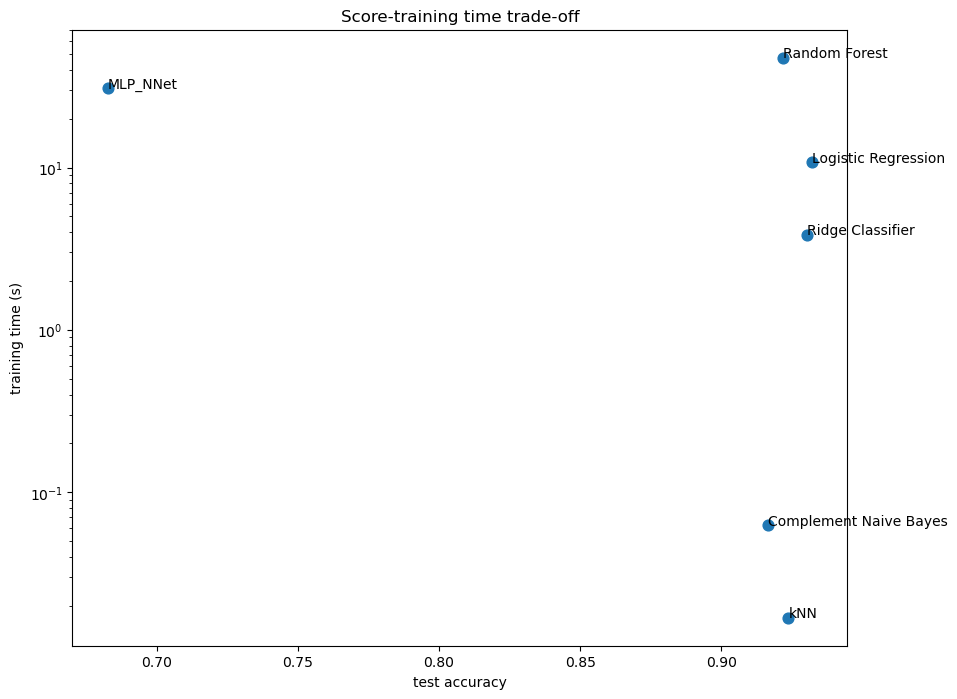

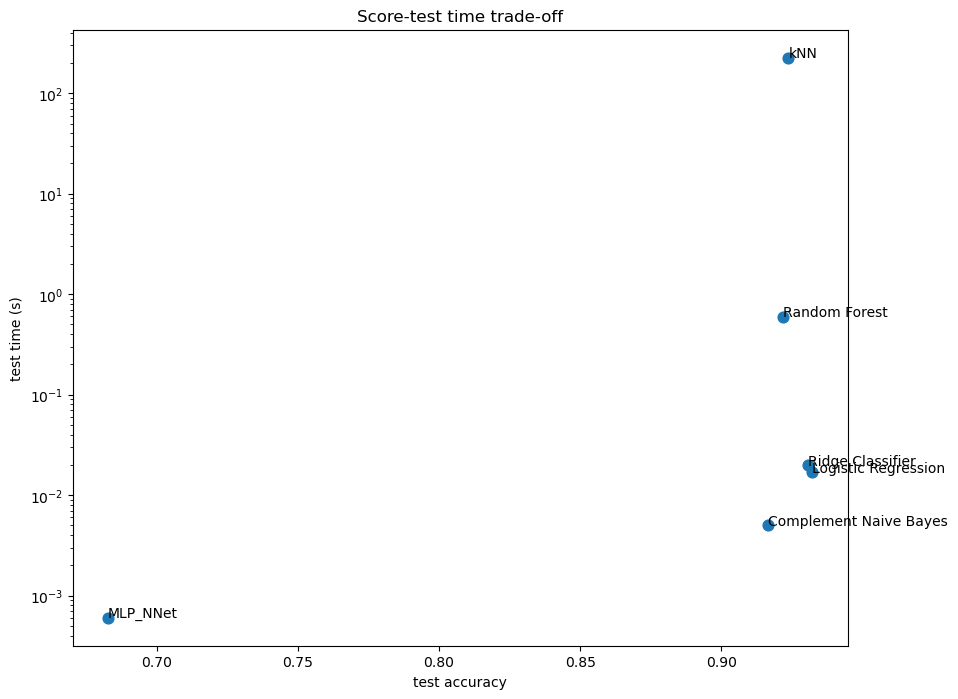

In [87]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (score[i], training_time[i]))
    ax2.annotate(txt, (score[i], test_time[i]))